In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#from autoencoder_models.DenoisingAutoencoder import MaskingNoiseAutoencoder

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

tf.compat.v1.reset_default_graph()
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test


def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]


X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

n_samples = int(mnist.train.num_examples)
training_epochs = 100
batch_size = 128
display_step = 1

autoencoder = MaskingNoiseAutoencoder(
    n_input=784,
    n_hidden=200,
    transfer_function=tf.nn.softplus,
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
    dropout_probability=0.95)

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        cost = autoencoder.partial_fit(batch_xs)

        avg_cost += cost / n_samples * batch_size

    if epoch % display_step == 0:
        print("Epoch:", '%d,' % (epoch + 1),
              "Cost:", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))





Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1, Cost: 20258.237988636
Epoch: 2, Cost: 12089.020513636
Epoch: 3, Cost: 11246.383782955
Epoch: 4, Cost: 10617.893118182
Epoch: 5, Cost: 10657.032382386
Epoch: 6, Cost: 10659.486810227
Epoch: 7, Cost: 10306.177198864
Epoch: 8, Cost: 9144.676110795
Epoch: 9, Cost: 9689.991711932
Epoch: 10, Cost: 8874.790157386
Epoch: 11, Cost: 8977.595514205
Epoch: 12, Cost: 9177.726928977
Epoch: 13, Cost: 10367.800349432
Epoch: 14, Cost: 8412.600667614
Epoch: 15, Cost: 8445.172475000
Epoch: 16, Cost: 9890.103865909
Epoch: 17, Cost: 9835.752619318
Epoch: 18, Cost: 9448.115893182
Epoch: 19, Cost: 9359.594681250
Epoch: 20, Cost: 8544.960557955
Epoch: 21, Cost: 8845.806814205
Epoch: 22, Cost: 9242.777289773
Epoch: 23, Cost: 8856.682291477
Epoch: 24, Cost: 8548.655350568
Epoch: 25, Cost: 9434.834988068
Epoch: 

In [0]:
class MaskingNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, optimizer = tf.train.AdamOptimizer(),
                 dropout_probability = 0.95):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.dropout_probability = dropout_probability
        self.keep_prob = tf.placeholder(tf.float32)

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(tf.nn.dropout(self.x, self.keep_prob), self.weights['w1']),
                                           self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.get_variable("w1", shape=[self.n_input, self.n_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer),
                                  feed_dict = {self.x: X, self.keep_prob: self.dropout_probability})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def generate(self, hidden=None):
        if hidden is None:
            hidden = self.sess.run(tf.random_normal([1, self.n_hidden]))
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

(55000, 784)


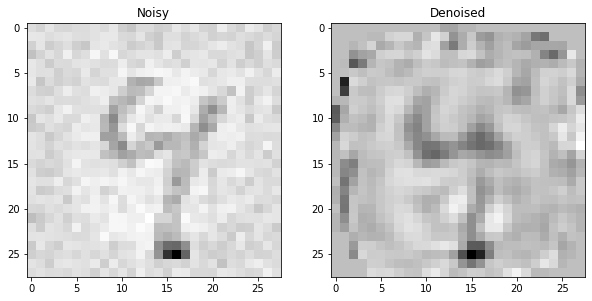

In [0]:
import matplotlib.pyplot as plt
#plt.imshow(autoencoder.generate().reshape(28,28), cmap='Greys')
noise_factor = 0.4
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0,
                                                         scale=1.0, size=X_train.shape)



plt.figure(1, figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(x_train_noisy[2,:].reshape(28,28), cmap='Greys')
plt.title('Noisy')
print(X_train.shape)
plt.subplot(1,2,2)
plt.imshow(
    autoencoder.reconstruct(x_train_noisy[2,:].reshape(1,-1)).reshape(28,28), 
    cmap='Greys')
plt.title('Denoised')
plt.show()

チュートリアル通りノイズの消去を試みたが、余計にノイズが増えてしまうという結果に終わった。

In [0]:
print(X_train[0,:].reshape(28, 28).shape)

(28, 28)


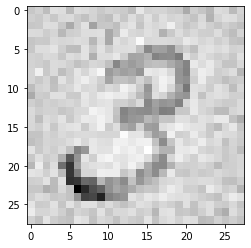

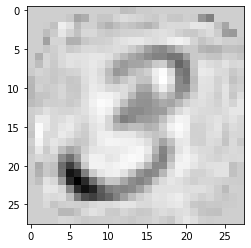

In [0]:
x_transformed = autoencoder.transform(X_train[1,:].reshape(1,784))
x_generated = autoencoder.generate(x_transformed)
x_reconstructed = autoencoder.reconstruct(x_generated)
plt.imshow(x_reconstructed.reshape(28, 28), cmap='Greys')

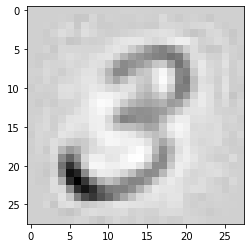

In [0]:
plt.imshow(x_generated.reshape(28, 28), cmap='Greys')

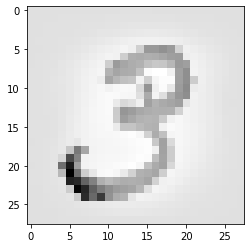

In [0]:
plt.imshow(X_train[1,:].reshape(28, 28), cmap='Greys')